In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import h5py
import datetime
import henon_map_cpp as hm
import scipy.integrate as integrate
import lmfit
from tqdm.notebook import tqdm
from numba import njit, cfunc, carray
from numba.types import intc, CPointer, float64

In [2]:
def linear_resid(params, x, data=None):
    a = params['a'].value
    b = params['b'].value
    model = a * x + b
    if data is None:
        return model
    return (model - data)

In [3]:
filepath = "/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/default_track.h5"

In [32]:
filepath = "/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_64.h5"

In [33]:
with h5py.File(filepath, "r") as f:
    attrs = dict(f.attrs)
    radiuses = f["radiuses"][...]
    angles = f["angles"][...]
    r_list = f["r_list"][...]
    angle_list = f["angle_list"][...]
    n_samples = len(radiuses)

In [34]:
attrs

{'angle_max': 1.5707963267948966,
 'angle_min': 0.0,
 'angle_samples': 50,
 'epsilon': 64.0,
 'mu': 0.0,
 'omega_x': 0.31,
 'omega_y': 0.32,
 'part_samples': 10000,
 'r_max': 0.22,
 'r_min': 0.1,
 'r_samples': 100,
 'std_I': 0.001,
 'std_angle': 0.001,
 'turn_mod_sample': 100,
 'turns': 100000,
 'turns_long_term': 100000}

In [35]:
with h5py.File(filepath, "r") as f:
    std_times = f["track_data/0/time_samples"][...]
    std_data = f["track_data/0/I_std"][...]

In [36]:
out_list = []
t_survival = []
actual_samples = []

for i in tqdm(range(n_samples)):
    with h5py.File(filepath, "r") as f:
        vx = f[f"track_data/{i}/time_samples"][...]
        vy = f[f"track_data/{i}/I_std"][...]
        steps = f[f"track_data/{i}/steps"][...]

    params = lmfit.Parameters()
    params.add('a', value=1.0)
    params.add('b', value=vy[0]**2)

    mask = np.logical_and(vx > 5000, vx < np.min([1e5, np.min(steps)]))
    
    if np.count_nonzero(mask) < 10:
        mask = vx < np.min([1e5, np.min(steps)])
    
    if np.count_nonzero(mask) < 4:
        out_list.append(None)
        t_survival.append(np.min(steps))
        continue
    
    vx = vx[mask]
    vy = vy[mask]

    actual_samples.append(vx)

    result = lmfit.minimize(linear_resid, params, args=(vx, vy**2))
    out_list.append(result)
    t_survival.append(np.min(steps))



  0%|          | 0/5000 [00:00<?, ?it/s]

In [37]:
t_survival = np.array(t_survival)
a_list = np.array([o.params["a"].value if o is not None else np.nan for o in out_list])
a_fixed = a_list.copy()
a_fixed[a_fixed <= 0] = np.nanmin(a_fixed[a_fixed > 0])
red_chi = np.array([o.redchi if o is not None else np.nan for o in out_list])

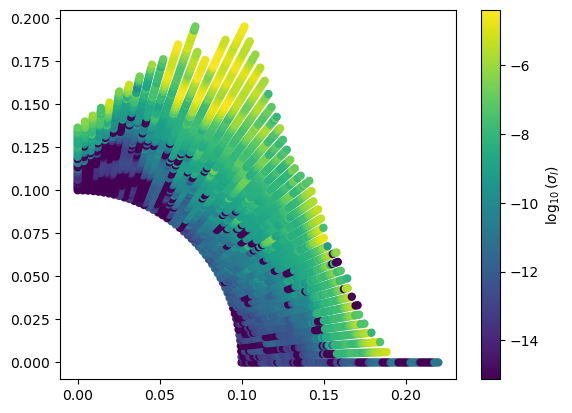

In [38]:
a_covered = a_fixed.copy()
a_covered[t_survival < 1e2] = np.nan
# a_covered[radiuses*np.cos(angles) > 0.31] = np.nan

plt.scatter(
    x=radiuses*np.cos(angles),
    y=radiuses*np.sin(angles),
    c=np.log10(a_covered),
    cmap="viridis",
    # vmin=-12,
    # vmax=-8,
    s=25
)

# create colorbar
cbar = plt.colorbar()
cbar.set_label(r"$\log_{10}(\sigma_I)$")

In [47]:
np.where(t_survival < 1000)

(array([ 193,  194,  195, ..., 4997, 4998, 4999]),)

In [48]:
i = 4195
with h5py.File(filepath, "r") as f:
    vx = f[f"track_data/{i}/time_samples"][...]
    vy = f[f"track_data/{i}/I_std"][...]
    steps = f[f"track_data/{i}/steps"][...]



In [31]:
print(np.min(steps))
print(t_survival[i])

476
476


(array([  2.,   3.,   4.,   1.,   6.,  13.,  10.,  16.,  17.,  19.,  18.,
         27.,  50.,  46.,  48.,  48.,  59.,  60.,  71.,  67.,  86.,  76.,
         99.,  92., 132., 167., 163., 159., 172., 155., 156., 150., 179.,
        183., 182., 194., 168., 201., 190., 171., 178., 206., 221., 204.,
        177., 212., 200., 188., 200., 178., 200., 201., 186., 164., 194.,
        184., 160., 159., 119., 168., 123., 129., 129., 140., 114., 119.,
        119., 111., 100.,  85., 102.,  85.,  85.,  74.,  61.,  70.,  68.,
         58.,  62.,  45.,  58.,  45.,  54.,  40.,  39.,  34.,  22.,  22.,
         25.,  20.,  19.,  19.,  22.,  24.,  16.,  24.,  15.,  17.,  14.,
        233.]),
 array([2.67760695, 2.70083088, 2.72405481, 2.74727874, 2.77050267,
        2.79372661, 2.81695054, 2.84017447, 2.8633984 , 2.88662233,
        2.90984626, 2.93307019, 2.95629412, 2.97951805, 3.00274198,
        3.02596591, 3.04918984, 3.07241377, 3.0956377 , 3.11886163,
        3.14208556, 3.16530949, 3.18853342, 3.

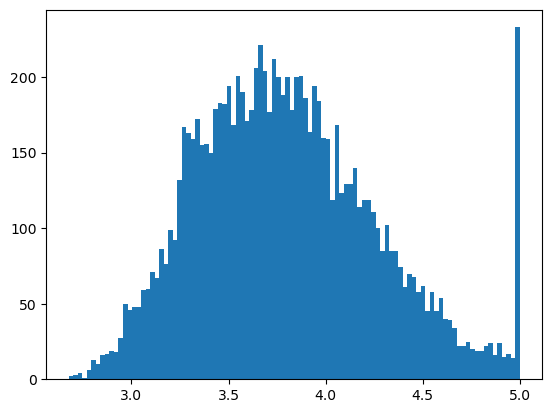

In [32]:
plt.hist(np.log10(steps), bins=100)

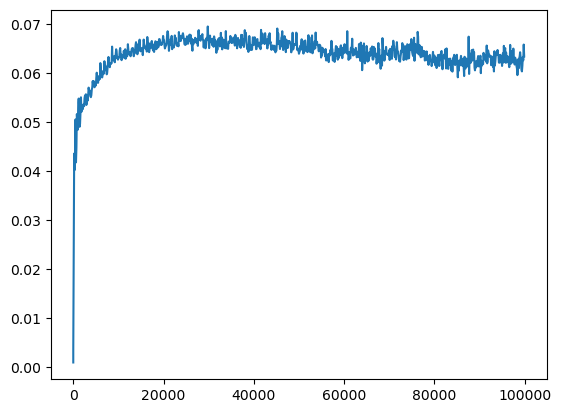

In [43]:
plt.plot(vx, vy)

In [39]:
a_mean = []
a_std = []
a_n_samples = []
r_unique = []
for r in np.unique(radiuses):
    r_unique.append(r)
    a_mean.append(np.nanmean(np.log10(a_covered)[radiuses == r]))
    a_std.append(np.nanstd(np.log10(a_covered)[radiuses == r]))
    a_n_samples.append(np.sum(np.logical_and(radiuses == r, np.isfinite(np.log10(a_covered)))))

r_unique = np.array(r_unique)
a_mean = np.array(a_mean)
a_std = np.array(a_std)
a_n_samples = np.array(a_n_samples)

<ErrorbarContainer object of 3 artists>

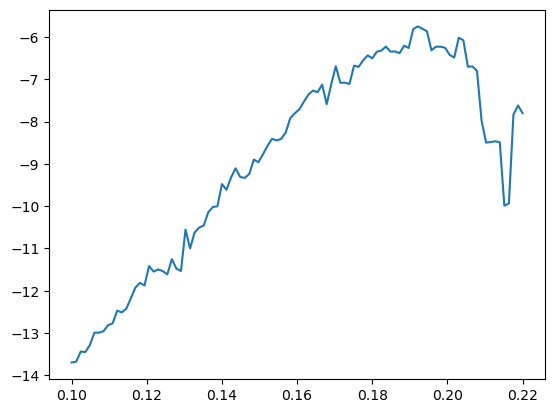

In [40]:
plt.errorbar(r_unique, a_mean)
# plt.yscale("log")

In [41]:
a_mean = []
a_std = []
a_n_samples = []
r_unique = []
for r in np.unique(radiuses):
    r_unique.append(r)
    a_mean.append(np.nanmean((a_covered)[radiuses == r]))
    a_std.append(np.nanstd((a_covered)[radiuses == r]))
    a_n_samples.append(np.sum(np.logical_and(radiuses == r, np.isfinite((a_covered)))))

r_unique = np.array(r_unique)
a_mean = np.array(a_mean)
a_std = np.array(a_std)
a_n_samples = np.array(a_n_samples)

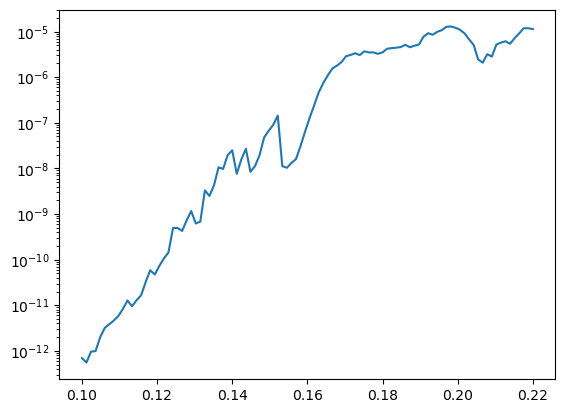

In [42]:
plt.errorbar(r_unique, a_mean)
plt.yscale("log")

In [155]:
@njit
def nek_d(kappa, I_ast, I):
    return np.exp(-2 * (I_ast/I) ** (1 / (2*kappa)))

@njit
def nek_d_extra(kappa, I_ast, extra, I):
    return np.exp(-(2 / extra) * (I_ast/I) ** (1 / (2*kappa)))


def nek_resid(params, x, data=None):
    kappa = params["kappa"].value
    I_ast = params["I_ast"].value
    # eps = params["eps"].value

    x_min = np.min(x)
    x_max = np.max(x)

    # integral = integrate.quad(lambda s: nek_d(kappa, I_ast, s), x_min, x_max)[0]
    # integral = 1.0
    
    # model = np.log10(nek_d(kappa, I_ast, x) / integral) + eps
    model = (nek_d(kappa, I_ast, x)) 
    # print(params)
    # print(model)
    if data is None:
        return model
    
    return (model - (data)) / data


def nek_resid_extra(params, x, data=None):
    kappa = params["kappa"].value
    I_ast = params["I_ast"].value
    extra = params["extra"].value
    # eps = params["eps"].value

    x_min = np.min(x)
    x_max = np.max(x)

    # integral = integrate.quad(lambda s: nek_d(kappa, I_ast, s), x_min, x_max)[0]
    # integral = 1.0
    
    # model = np.log10(nek_d(kappa, I_ast, x) / integral) + eps
    model = (nek_d_extra(kappa, I_ast, extra, x)) 
    # print(params)
    # print(model)
    if data is None:
        return model
    
    return (model - (data)) / data


def culo_resid(params, x, data=None):
    b = params["b"].value
    c = params["c"].value
    
    # model = np.log10(nek_d(kappa, I_ast, x) / integral) + eps
    model = np.exp(-2 * (c/x**b))
    # print(params)
    # print(model)
    if data is None:
        return model
    
    return (model - (data))

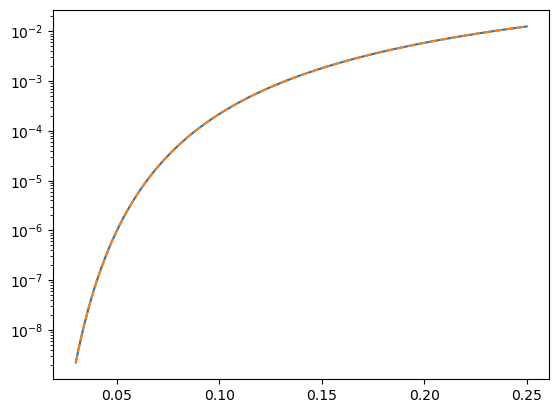

In [160]:
tautologic_k = 0.7
tautologic_I_ast = 0.75
# tautologic_eps = 7.0

tmp_r = np.linspace(0.03, 0.25, 1000)
tmp_nek_d = (nek_d(tautologic_k, tautologic_I_ast, tmp_r))

params = lmfit.Parameters()
params.add('kappa', value=0.85, min=0.01, max=3.0)
params.add('I_ast', value=1, min=0.0001, max=100)
# params.add('eps', value=10)


plt.plot(tmp_r, tmp_nek_d, label='nek_d')
result = lmfit.minimize(nek_resid, params, args=(tmp_r, tmp_nek_d))
plt.plot(tmp_r, nek_resid(result.params, tmp_r), label='fit', ls='--')
plt.yscale("log")
result


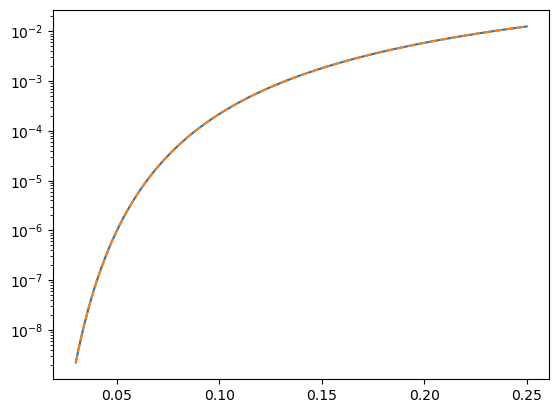

In [164]:
tautologic_k = 0.7
tautologic_I_ast = 0.75
tautologic_extra = 1.0

tmp_r = np.linspace(0.03, 0.25, 1000)
tmp_nek_d = (nek_d_extra(tautologic_k, tautologic_I_ast, tautologic_extra, tmp_r))

params = lmfit.Parameters()
params.add('kappa', value=0.7, min=0.01, max=3.0, vary=False)
params.add('I_ast', value=1, min=0.0001, max=100)
params.add('extra', value=1, min=0.0001, max=100)
# params.add('eps', value=10)


plt.plot(tmp_r, tmp_nek_d, label='nek_d')
result = lmfit.minimize(nek_resid_extra, params, args=(tmp_r, tmp_nek_d))
plt.plot(tmp_r, nek_resid_extra(result.params, tmp_r), label='fit', ls='--')
plt.yscale("log")
result


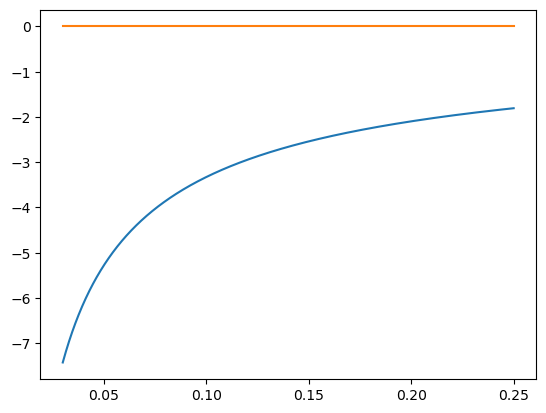

In [154]:
tautologic_k = 0.75
tautologic_I_ast = 0.75
tautologic_eps = -0.0

tmp_r = np.linspace(0.03, 0.25, 1000)
tmp_nek_d = np.log10(nek_d(tautologic_k, tautologic_I_ast, tmp_r)) + tautologic_eps

params = lmfit.Parameters()
params.add('kappa', value=0.5, min=0.01, max=3.0)
params.add('I_ast', value=1, min=0.0001, max=100)
params.add('eps', value=0, vary=False)


plt.plot(tmp_r, tmp_nek_d, label='nek_d')
result = lmfit.minimize(nek_resid, params, args=(tmp_r, tmp_nek_d))
plt.plot(tmp_r, nek_resid(result.params, tmp_r), label='fit')
# plt.yscale("log")

In [81]:
out_list = []

for i in np.linspace(0.0, 0.065, 100):
    # print(i)
    params = lmfit.Parameters()
    params.add('kappa', value=0.5, min=0.01, max=3.0)
    params.add('I_ast', value=5, min=0.0001, max=100)
    params.add('eps', value=0)

    xx = r_unique**2
    yy = a_mean

    mask = xx > i
    xx = xx[mask]
    yy = yy[mask]

    integral = integrate.simps(yy, xx)
    integral = 1.0
    yy = yy / integral

    yy = (yy)

    result = lmfit.minimize(nek_resid, params, args=(xx, yy))
    out_list.append(result)

result

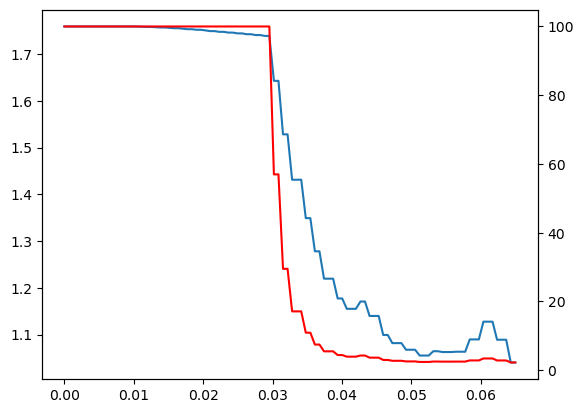

In [82]:
kappa = [out_list.params["kappa"].value for out_list in out_list]
I_ast = [out_list.params["I_ast"].value for out_list in out_list]

plt.plot(np.linspace(0.0, 0.065, 100), kappa)
plt.twinx()
plt.plot(np.linspace(0.0, 0.065, 100), I_ast, color="red")
# plt.yscale("log")

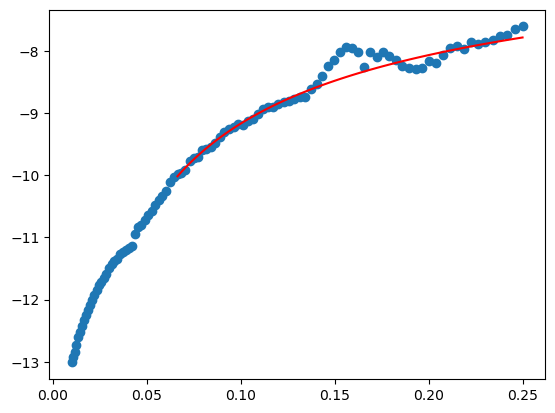

In [83]:
plt.scatter(r_unique**2, np.log10(a_mean / integral))
plt.plot(xx, np.log10(nek_resid(result.params, xx)), color='red')

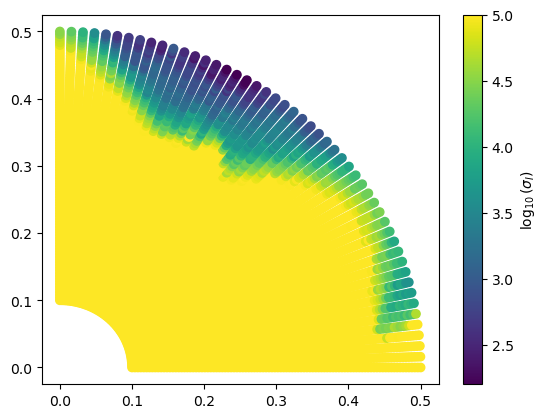

In [9]:
plt.scatter(
    x=radiuses*np.cos(angles),
    y=radiuses*np.sin(angles),
    c=np.log10(t_survival),
    cmap="viridis",
    # vmin=-10
)

# create colorbar
cbar = plt.colorbar()
cbar.set_label(r"$\log_{10}(\sigma_I)$")

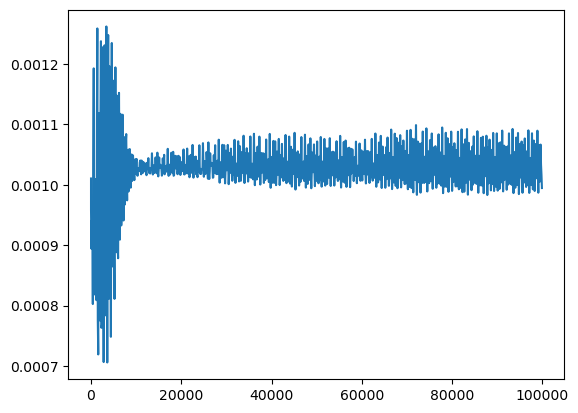

In [65]:
plt.plot(std_times, std_data)

In [3]:
f_list = [
    ("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_0.h5", 0.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_4.h5", 4.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_8.h5", 8.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_16.h5", 16.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_24.h5", 24.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_32.h5", 32.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_42.h5", 42.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_64.h5", 64.0)
]

In [11]:
f_lyap_list = [
    ("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_0.h5", 0.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_4.h5", 4.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_8.h5", 8.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_16.h5", 16.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_24.h5", 24.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_32.h5", 32.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_42.h5", 42.0)
    ,("/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_64.h5", 64.0)
]

In [96]:
lyapunov = []
lyapunov_b = []
lyap_rr = []
lyap_aa = []
lyap_steps = []

for fn, eps in tqdm(f_lyap_list):
    print(fn)
    with h5py.File(fn, "r") as f:
        lyapunov.append(f["track_data/lyapunov_x"][...])
        lyapunov_b.append(f["track_data/lyapunov_b_x"][...])
        lyap_rr.append(f["track_data/r"][...])
        lyap_aa.append(f["track_data/a"][...])
        lyap_steps.append(f["track_data/steps"][...])

  0%|          | 0/8 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_0.h5
/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_4.h5
/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_8.h5
/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_16.h5
/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_24.h5
/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_32.h5
/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_42.h5
/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lyap_default_track_64.h5


/tmp/ipykernel_5007/2018545711.py:4: RuntimeWarning: invalid value encountered in log10
  c=np.log10(lyapunov_b[2]),


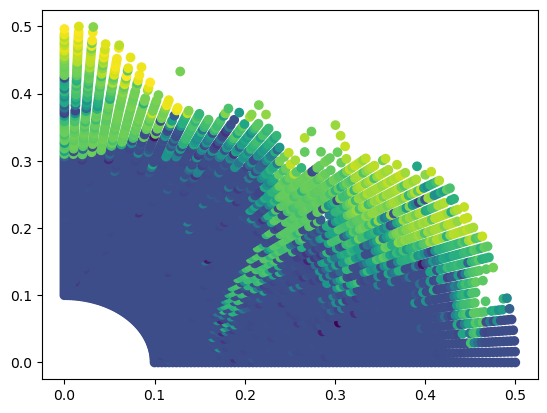

In [97]:
plt.scatter(
    x=lyap_rr[2] * np.cos(lyap_aa[2]),
    y=lyap_rr[2] * np.sin(lyap_aa[2]),
    c=np.log10(lyapunov_b[2]),
)

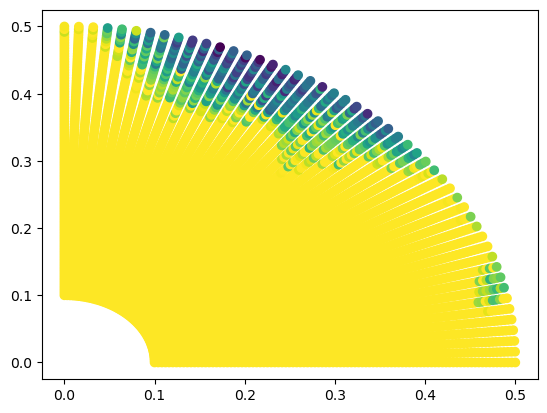

In [16]:
plt.scatter(
    x=lyap_rr[2] * np.cos(lyap_aa[2]),
    y=lyap_rr[2] * np.sin(lyap_aa[2]),
    c=np.log10(lyap_steps[2]),
)

In [19]:
def moving_mean(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [4]:
eps = []
r_mean_list = []
a_mean_list = []
a_n_samples_list = []
steps_list = []

a_vals_list = []
b_vals_list = []
red_chi_list = []
rr_vals_list = []
aa_vals_list = []

for fn, eps in tqdm(f_list):
    print(fn)
    with h5py.File(fn, "r") as f:
        attrs = dict(f.attrs)
        radiuses = f["radiuses"][...]
        angles = f["angles"][...]
        r_list = f["r_list"][...]
        angle_list = f["angle_list"][...]
        n_samples = len(radiuses)
    
    out_list = []
    t_survival = []
    actual_samples = []

    for i in tqdm(range(n_samples)):
        with h5py.File(fn, "r") as f:
            vx = f[f"track_data/{i}/time_samples"][...]
            vy = f[f"track_data/{i}/I_std"][...]
            steps = f[f"track_data/{i}/steps"][...]

        mask = np.logical_and(vx > 5000, vx < np.min([1e5, np.min(steps)]))
        if np.count_nonzero(mask) < 10:
            mask = vx < np.min([1e5, np.min(steps)])

        if np.count_nonzero(mask) < 4:
            out_list.append(None)
            t_survival.append(np.min(steps))
            continue

        vx = vx[mask]
        vy = vy[mask]

        params = lmfit.Parameters()
        params.add('a', value=1.0)
        params.add('b', value=vy[0]**2)

        actual_samples.append(vx)

        result = lmfit.minimize(linear_resid, params, args=(vx, vy**2))
        out_list.append(result)
        t_survival.append(np.min(steps))

    t_survival = np.array(t_survival)
    a_list = np.array([o.params["a"].value if o is not None else np.nan for o in out_list])
    a_fixed = a_list.copy()
    a_fixed[a_fixed <= 0] = np.nanmin(a_fixed[a_fixed > 0])

    b_list = np.array([o.params["b"].value if o is not None else np.nan for o in out_list])
    b_fixed = b_list.copy()
    b_fixed[b_fixed <= 0] = np.nanmin(b_fixed[b_fixed > 0])

    red_chi = np.array([o.redchi if o is not None else np.nan for o in out_list])

    a_covered = a_fixed.copy()
    a_covered[t_survival < 1e2] = np.nan

    b_covered = b_fixed.copy()
    b_covered[t_survival < 1e2] = np.nan

    a_vals_list.append(a_covered)
    b_vals_list.append(b_covered)
    red_chi_list.append(red_chi)
    rr_vals_list.append(radiuses)
    aa_vals_list.append(angles)

    plt.figure()
    plt.scatter(
        x=radiuses*np.cos(angles),
        y=radiuses*np.sin(angles),
        c=np.log10(a_covered),
        cmap="viridis",
    )
    plt.xlabel("$x_0$")
    plt.ylabel("$y_0$")
    cbar = plt.colorbar()
    cbar.set_label("$\\log_{{10}}(D_{{num}})$")
    plt.title(f"Modulated Hénon map, $\\epsilon = {eps}$")
    plt.savefig(f"/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/eps_{eps:.0f}_a.png", dpi=300)
    plt.close()

    a_mean = []
    a_std = []
    a_n_samples = []
    r_unique = []
    for r in np.unique(radiuses):
        r_unique.append(r)
        a_mean.append(np.nanmean(a_covered[radiuses == r]))
        a_std.append(np.nanstd(a_covered[radiuses == r]))
        a_n_samples.append(np.sum(np.logical_and(radiuses == r, np.isfinite(a_covered))))

    r_unique = np.array(r_unique)
    a_mean = np.array(a_mean)
    a_std = np.array(a_std)
    a_n_samples = np.array(a_n_samples)

    r_mean_list.append(r_unique)
    a_mean_list.append(a_mean)
    a_n_samples_list.append(a_n_samples)
    steps_list.append(steps)


  0%|          | 0/8 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_0.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_4.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_8.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_16.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_24.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_32.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_42.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/HPC/camontan/lhc_paper_indicators/data/henon_diffusion/lhc_top_64.h5


  0%|          | 0/5000 [00:00<?, ?it/s]

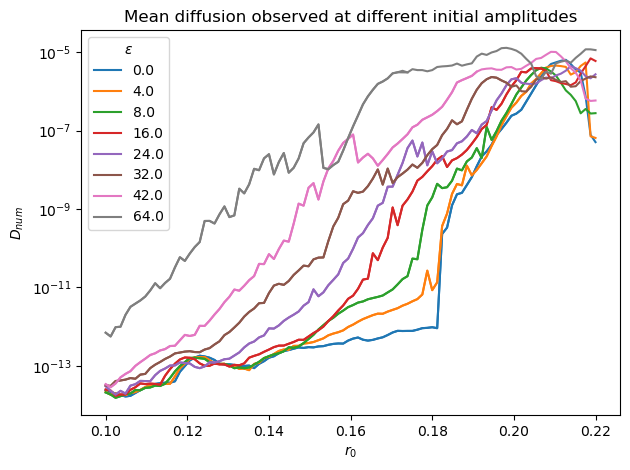

In [10]:
for i, (r, a, s, n) in enumerate(zip(r_mean_list, a_mean_list, f_list, a_n_samples_list)):
    mask = n >= 30
    plt.plot(r[mask], a[mask], label=f"{s[1]}", c=f"C{i}")
    plt.plot(r, a, c=f"C{i}")

plt.yscale("log")
plt.legend(title="$\\epsilon$")
plt.xlabel("$r_0$")
plt.ylabel("$D_{num}$")
plt.title("Mean diffusion observed at different initial amplitudes")

plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_all.png", dpi=300)

In [11]:
for i, (r, a, s, n) in enumerate(zip(r_mean_list, a_mean_list, f_list, a_n_samples_list)):
    mask = n >= 30
    plt.figure()
    plt.plot(r[mask], a[mask], label=f"{s[1]}", c=f"C{i}")
    plt.plot(r, a, c=f"C{i}")
    plt.plot([], [], c="black", ls="--", label="Valid samples")

    plt.yscale("log")
    plt.legend(title="$\\epsilon$", loc="center left")
    plt.xlabel("$r_0$")
    plt.ylabel("$D_{num}$")

    plt.twinx()
    plt.plot(r, n, c="black", ls="--", label="Valid samples")
    plt.ylabel("Valid samples")

    plt.title("Mean diffusion observed at different initial amplitudes")

    plt.tight_layout()
    plt.savefig(f"/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_eps_{int(s[1])}.png", dpi=300)
    plt.close()

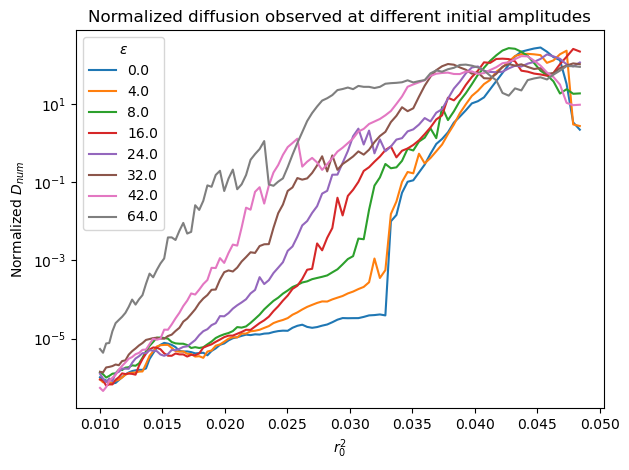

In [17]:
xx = r_unique ** 2
xx_list = []
yy = np.array(a_mean_list)[:].copy()
yy_list = []
thresh = -6.5
for i in range(len(yy)):
    integral = integrate.simps(yy[i], xx)
    yy[i] /= integral
    
    mask = np.logical_and(a_n_samples_list[i] >= 1, yy[i] > 10**thresh)
    
    xx_list.append(xx[mask])
    yy_list.append(yy[i][mask])
    plt.plot(xx[mask], yy[i][mask], label=f"{f_list[i][1]}")
plt.yscale("log")

plt.xlabel("$r_0^2$")
plt.ylabel("Normalized $D_{{num}}$")
plt.title("Normalized diffusion observed at different initial amplitudes")
plt.legend(title="$\\epsilon$")
plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_all_normalized.png", dpi=300)

In [18]:
@njit
def nek_d(kappa, I_ast, I):
    return np.exp(-2 * (I_ast/I) ** (1 / (2*kappa)))


def nek_resid(params, x, data=None):
    kappa = params["kappa"].value

    len_x = len(list(filter(lambda x: x.startswith("I_ast_"), params.keys())))

    I_ast = [params[f"I_ast_{i}"].value for i in range(len_x)]
    # eps = [params[f"eps_{i}"].value for i in range(len_x)]

    integral = []
    for i in range(len_x):
        x_min = params["x_min"].value
        x_max = params["x_max"].value
        # print(x_min, x_max)
        iiii = (integrate.quad(lambda s: nek_d(kappa, I_ast[i], s), x_min, x_max)[0])
        # print(iiii)
        integral.append(iiii)
        # integral.append(1)

    model = [np.log10(nek_d(kappa, I_ast[i], x[i]) / integral[i]) for i in range(len_x)]

    if data is None:
        return model
    
    return np.concatenate([m - d for m, d in zip(model, data)])

In [19]:
params = lmfit.Parameters()
params.add('kappa', value=0.3, min=0.1, max=3.0)
params.add('I_ast_0', value=0.2, min=0.01, max=1000)
params.add('I_ast_1', value=0.2, min=0.01, max=1000)
params.add('I_ast_2', value=0.2, min=0.01, max=1000)
params.add('I_ast_3', value=0.2, min=0.01, max=1000)
params.add('I_ast_4', value=0.2, min=0.01, max=1000)
params.add('I_ast_5', value=0.2, min=0.01, max=1000)
params.add('I_ast_6', value=0.2, min=0.01, max=1000)
params.add('I_ast_7', value=0.2, min=0.01, max=1000)

params.add("x_min", value=np.min(xx), vary=False)
params.add("x_max", value=np.max(xx), vary=False)

result_global = lmfit.minimize(nek_resid, params, args=(xx_list,[np.log10(y) for y in yy_list]))
result_global

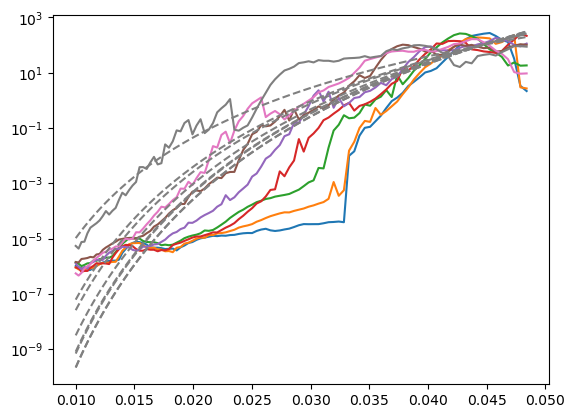

In [20]:
model = nek_resid(result_global.params, xx_list)

for x, y in zip(xx_list, yy_list):
    plt.plot(x, y)

for x, y in zip(xx_list, model):
    plt.plot(x, 10**y, "--", color="grey")

plt.yscale("log")

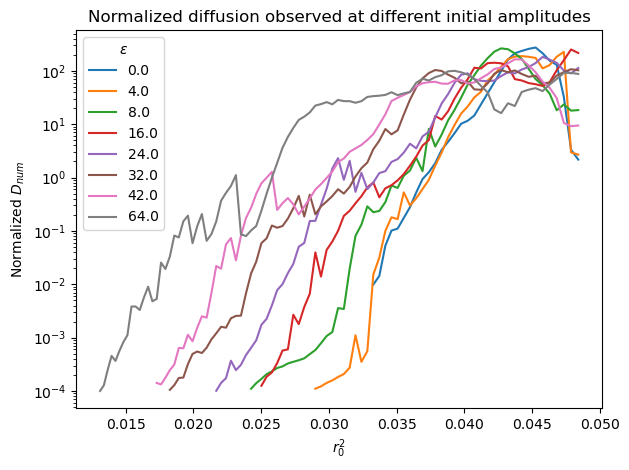

In [22]:
xx = r_unique ** 2
xx_list = []
yy = np.array(a_mean_list)[:].copy()
yy_list = []
thresh = -4.
for i in range(len(yy)):
    integral = integrate.simps(yy[i], xx)
    yy[i] /= integral
    
    mask = np.logical_and(a_n_samples_list[i] >= 1, yy[i] > 10**thresh)
    
    xx_list.append(xx[mask])
    yy_list.append(yy[i][mask])
    plt.plot(xx[mask], yy[i][mask], label=f"{f_list[i][1]}")
plt.yscale("log")

plt.xlabel("$r_0^2$")
plt.ylabel("Normalized $D_{{num}}$")
plt.title("Normalized diffusion observed at different initial amplitudes")
plt.legend(title="$\\epsilon$")
plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_all_normalized_cuts_down.png", dpi=300)

In [23]:
params = lmfit.Parameters()
params.add('kappa', value=0.3, min=0.1, max=3.0)
params.add('I_ast_0', value=0.2, min=0.01, max=1000)
params.add('I_ast_1', value=0.2, min=0.01, max=1000)
params.add('I_ast_2', value=0.2, min=0.01, max=1000)
params.add('I_ast_3', value=0.2, min=0.01, max=1000)
params.add('I_ast_4', value=0.2, min=0.01, max=1000)
params.add('I_ast_5', value=0.2, min=0.01, max=1000)
params.add('I_ast_6', value=0.2, min=0.01, max=1000)
params.add('I_ast_7', value=0.2, min=0.01, max=1000)

params.add("x_min", value=np.min(xx), vary=False)
params.add("x_max", value=np.max(xx), vary=False)

result_global = lmfit.minimize(nek_resid, params, args=(xx_list,[np.log10(y) for y in yy_list]))
result_global

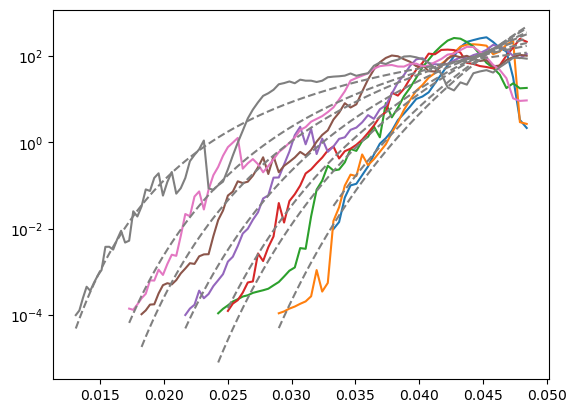

In [24]:
model = nek_resid(result_global.params, xx_list)

for x, y in zip(xx_list, yy_list):
    plt.plot(x, y)

for x, y in zip(xx_list, model):
    plt.plot(x, 10**y, "--", color="grey")

plt.yscale("log")

In [38]:
thresh_list = np.linspace(-5, -3, 21)
results_cut_down_list = []

for thresh in thresh_list:
    xx = r_unique ** 2
    xx_list = []
    yy = np.array(a_mean_list)[:].copy()
    yy_list = []
    # thresh = -4.
    plt.figure()
    for i in range(len(yy)):
        integral = integrate.simps(yy[i], xx)
        yy[i] /= integral
        
        mask = np.logical_and(a_n_samples_list[i] >= 1, yy[i] > 10**thresh)
        
        xx_list.append(xx[mask])
        yy_list.append(yy[i][mask])
        plt.plot(xx[mask], yy[i][mask], label=f"{f_list[i][1]}")
    plt.yscale("log")

    plt.xlabel("$r_0^2$")
    plt.ylabel("Normalized $D_{{num}}$")
    plt.title("Normalized diffusion observed at different initial amplitudes")
    plt.legend(title="$\\epsilon$")
    plt.tight_layout()
    plt.savefig(f"/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_all_normalized_cuts_down_thresh_{thresh:.1f}.png", dpi=300)
    plt.close()

    params = lmfit.Parameters()
    params.add('kappa', value=0.3, min=0.1, max=3.0)
    params.add('I_ast_0', value=0.2, min=0.01, max=1000)
    params.add('I_ast_1', value=0.2, min=0.01, max=1000)
    params.add('I_ast_2', value=0.2, min=0.01, max=1000)
    params.add('I_ast_3', value=0.2, min=0.01, max=1000)
    params.add('I_ast_4', value=0.2, min=0.01, max=1000)
    params.add('I_ast_5', value=0.2, min=0.01, max=1000)
    params.add('I_ast_6', value=0.2, min=0.01, max=1000)
    params.add('I_ast_7', value=0.2, min=0.01, max=1000)

    params.add("x_min", value=np.min(xx), vary=False)
    params.add("x_max", value=np.max(xx), vary=False)

    result_global = lmfit.minimize(nek_resid, params, args=(xx_list,[np.log10(y) for y in yy_list]))
    results_cut_down_list.append(result_global)

    plt.figure()
    model = nek_resid(result_global.params, xx_list)

    for x, y in zip(xx_list, yy_list):
        plt.plot(x, y)

    for x, y in zip(xx_list, model):
        plt.plot(x, 10**y, "--", color="grey")

    plt.yscale("log")
    plt.ylabel("Normalized $D_{{num}}$")
    plt.xlabel("$r_0^2$")
    plt.savefig(f"/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_all_normalized_cuts_down_thresh_{thresh:.1f}_fit.png", dpi=300)
    plt.close()

In [42]:
kappa_list = np.array([r.params["kappa"].value for r in results_cut_down_list])
I_ast_0_list = np.array([r.params["I_ast_0"].value for r in results_cut_down_list])
I_ast_1_list = np.array([r.params["I_ast_1"].value for r in results_cut_down_list])
I_ast_2_list = np.array([r.params["I_ast_2"].value for r in results_cut_down_list])
I_ast_3_list = np.array([r.params["I_ast_3"].value for r in results_cut_down_list])
I_ast_4_list = np.array([r.params["I_ast_4"].value for r in results_cut_down_list])
I_ast_5_list = np.array([r.params["I_ast_5"].value for r in results_cut_down_list])
I_ast_6_list = np.array([r.params["I_ast_6"].value for r in results_cut_down_list])
I_ast_7_list = np.array([r.params["I_ast_7"].value for r in results_cut_down_list])

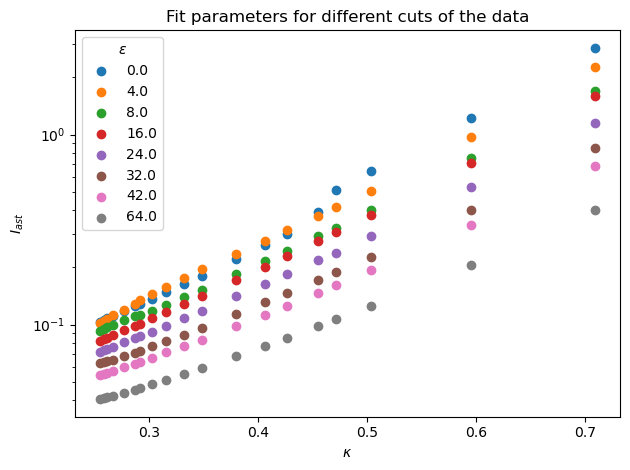

In [52]:
plt.scatter(kappa_list[2:], I_ast_0_list[2:], label=str(f_list[0][1]))
plt.scatter(kappa_list[2:], I_ast_1_list[2:], label=str(f_list[1][1]))
plt.scatter(kappa_list[2:], I_ast_2_list[2:], label=str(f_list[2][1]))
plt.scatter(kappa_list[2:], I_ast_3_list[2:], label=str(f_list[3][1]))
plt.scatter(kappa_list[2:], I_ast_4_list[2:], label=str(f_list[4][1]))
plt.scatter(kappa_list[2:], I_ast_5_list[2:], label=str(f_list[5][1]))
plt.scatter(kappa_list[2:], I_ast_6_list[2:], label=str(f_list[6][1]))
plt.scatter(kappa_list[2:], I_ast_7_list[2:], label=str(f_list[7][1]))
plt.yscale("log")
plt.legend(title="$\\epsilon$")
plt.xlabel("$\\kappa$")
plt.ylabel("$I_{ast}$")
plt.title("Fit parameters for different cuts of the data")
plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/fit_params_cuts.png", dpi=300)

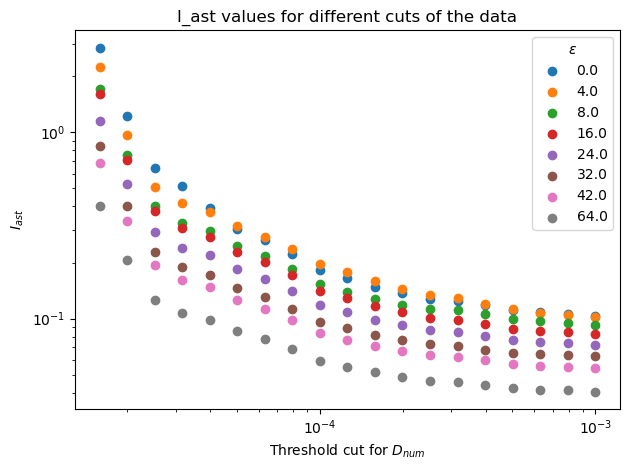

In [54]:
plt.scatter(10**thresh_list[2:], I_ast_0_list[2:], label=str(f_list[0][1]))
plt.scatter(10**thresh_list[2:], I_ast_1_list[2:], label=str(f_list[1][1]))
plt.scatter(10**thresh_list[2:], I_ast_2_list[2:], label=str(f_list[2][1]))
plt.scatter(10**thresh_list[2:], I_ast_3_list[2:], label=str(f_list[3][1]))
plt.scatter(10**thresh_list[2:], I_ast_4_list[2:], label=str(f_list[4][1]))
plt.scatter(10**thresh_list[2:], I_ast_5_list[2:], label=str(f_list[5][1]))
plt.scatter(10**thresh_list[2:], I_ast_6_list[2:], label=str(f_list[6][1]))
plt.scatter(10**thresh_list[2:], I_ast_7_list[2:], label=str(f_list[7][1]))
plt.yscale("log")
plt.xscale("log")
plt.legend(title="$\\epsilon$")
plt.xlabel("Threshold cut for $D_{num}$")
plt.ylabel("$I_{ast}$")
plt.title("I_ast values for different cuts of the data")
plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/fit_params_cuts_thresh_Iast.png", dpi=300)

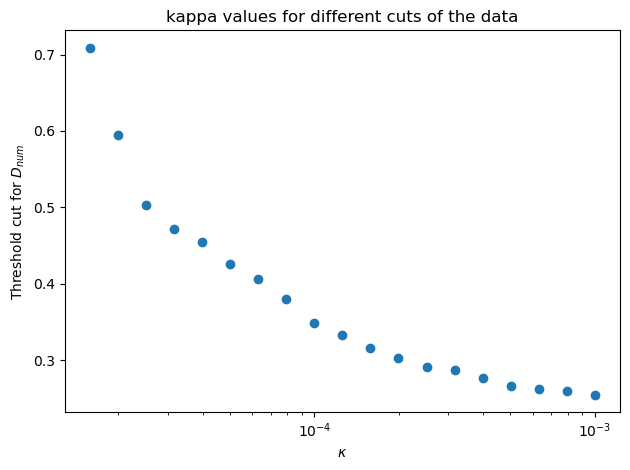

In [56]:
plt.scatter(10**thresh_list[2:], kappa_list[2:], label=str(f_list[0][1]))
plt.xscale("log")
plt.xlabel("$\kappa$")
plt.ylabel("Threshold cut for $D_{num}$")
plt.title("kappa values for different cuts of the data")
plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/fit_params_cuts_thresh_kappa.png", dpi=300)

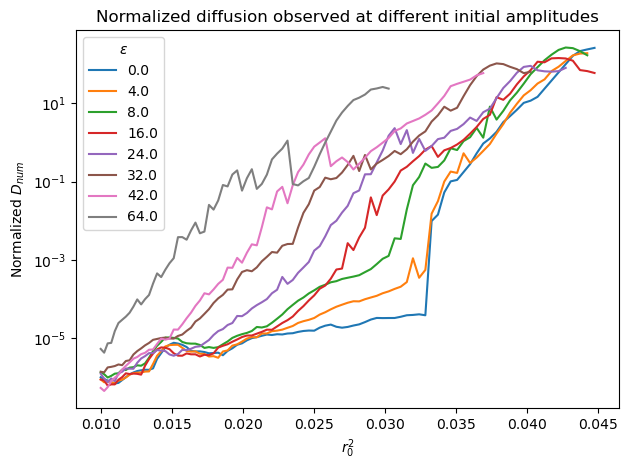

In [25]:
xx = r_unique ** 2
xx_list = []
yy = np.array(a_mean_list)[:].copy()
yy_list = []
thresh = -6.5
for i in range(len(yy)):
    integral = integrate.simps(yy[i], xx)
    yy[i] /= integral
    
    mask = np.logical_and(a_n_samples_list[i] >= 25, yy[i] > 10**thresh)
    
    xx_list.append(xx[mask])
    yy_list.append(yy[i][mask])
    plt.plot(xx[mask], yy[i][mask], label=f"{f_list[i][1]}")
plt.yscale("log")

plt.xlabel("$r_0^2$")
plt.ylabel("Normalized $D_{{num}}$")
plt.title("Normalized diffusion observed at different initial amplitudes")
plt.legend(title="$\\epsilon$")
plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_all_normalized_cuts_up.png", dpi=300)

In [26]:
params = lmfit.Parameters()
params.add('kappa', value=0.3, min=0.1, max=3.0)
params.add('I_ast_0', value=0.2, min=0.01, max=1000)
params.add('I_ast_1', value=0.2, min=0.01, max=1000)
params.add('I_ast_2', value=0.2, min=0.01, max=1000)
params.add('I_ast_3', value=0.2, min=0.01, max=1000)
params.add('I_ast_4', value=0.2, min=0.01, max=1000)
params.add('I_ast_5', value=0.2, min=0.01, max=1000)
params.add('I_ast_6', value=0.2, min=0.01, max=1000)
params.add('I_ast_7', value=0.2, min=0.01, max=1000)

params.add("x_min", value=np.min(xx), vary=False)
params.add("x_max", value=np.max(xx), vary=False)

result_global = lmfit.minimize(nek_resid, params, args=(xx_list,[np.log10(y) for y in yy_list]))
result_global

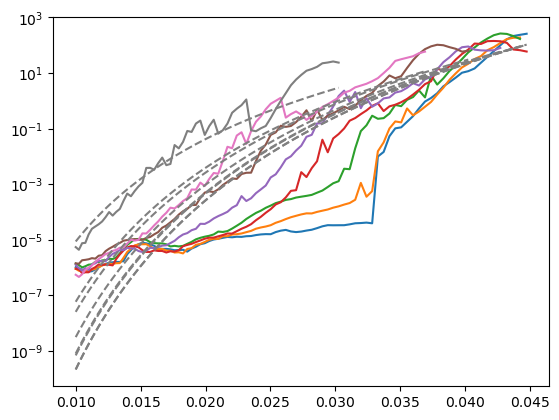

In [27]:
model = nek_resid(result_global.params, xx_list)

for x, y in zip(xx_list, yy_list):
    plt.plot(x, y)

for x, y in zip(xx_list, model):
    plt.plot(x, 10**y, "--", color="grey")

plt.yscale("log")

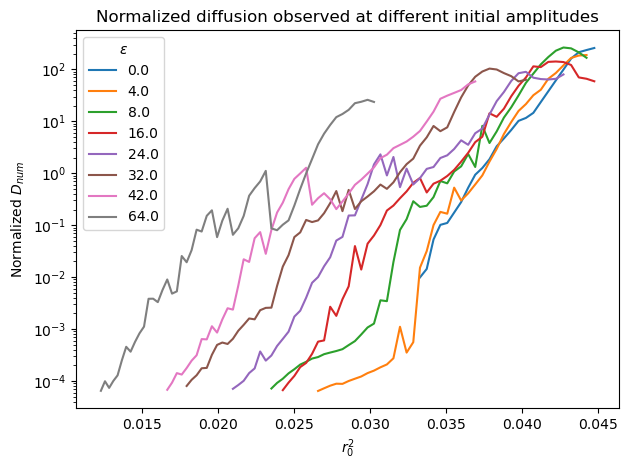

In [30]:
xx = r_unique ** 2
xx_list = []
yy = np.array(a_mean_list)[:].copy()
yy_list = []
thresh = -4.2
for i in range(len(yy)):
    integral = integrate.simps(yy[i], xx)
    yy[i] /= integral
    
    mask = np.logical_and(a_n_samples_list[i] >= 25, yy[i] > 10**thresh)
    
    xx_list.append(xx[mask])
    yy_list.append(yy[i][mask])
    plt.plot(xx[mask], yy[i][mask], label=f"{f_list[i][1]}")
plt.yscale("log")

plt.xlabel("$r_0^2$")
plt.ylabel("Normalized $D_{{num}}$")
plt.title("Normalized diffusion observed at different initial amplitudes")
plt.legend(title="$\\epsilon$")
plt.tight_layout()
plt.savefig("/home/HPC/camontan/lhc_paper_indicators/img/henon_diffusion/diffusion_all_normalized_cuts_both.png", dpi=300)

In [31]:
params = lmfit.Parameters()
params.add('kappa', value=0.3, min=0.1, max=3.0)
params.add('I_ast_0', value=0.2, min=0.01, max=1000)
params.add('I_ast_1', value=0.2, min=0.01, max=1000)
params.add('I_ast_2', value=0.2, min=0.01, max=1000)
params.add('I_ast_3', value=0.2, min=0.01, max=1000)
params.add('I_ast_4', value=0.2, min=0.01, max=1000)
params.add('I_ast_5', value=0.2, min=0.01, max=1000)
params.add('I_ast_6', value=0.2, min=0.01, max=1000)
params.add('I_ast_7', value=0.2, min=0.01, max=1000)

params.add("x_min", value=np.min(xx), vary=False)
params.add("x_max", value=np.max(xx), vary=False)

result_global = lmfit.minimize(nek_resid, params, args=(xx_list,[np.log10(y) for y in yy_list]))
result_global

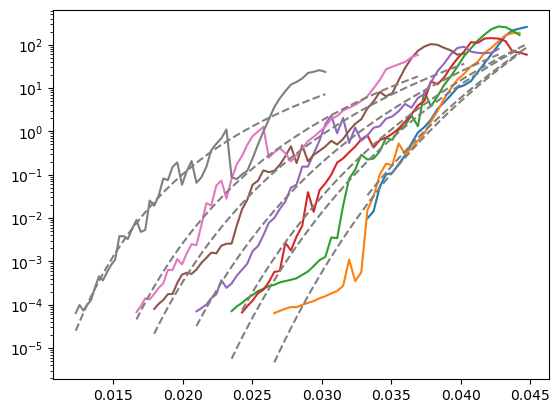

In [32]:
model = nek_resid(result_global.params, xx_list)

for x, y in zip(xx_list, yy_list):
    plt.plot(x, y)

for x, y in zip(xx_list, model):
    plt.plot(x, 10**y, "--", color="grey")

plt.yscale("log")

In [187]:
result_individual_fixed_k = []

for i in tqdm(range(len(xx_list))):
    params = lmfit.Parameters()
    params.add('kappa', value=result_global.params["kappa"].value, vary=False)
    params.add('I_ast_0', value=0.2, min=0.01, max=100)

    params.add("x_min", value=np.min(xx), vary=False)
    params.add("x_max", value=np.max(xx), vary=False)

    result = lmfit.minimize(nek_resid, params, args=([xx_list[i]],[np.log10(yy_list[i])]))
    result_individual_fixed_k.append(result)

  0%|          | 0/8 [00:00<?, ?it/s]

In [172]:
result_individual_vary_k = []

for i in tqdm(range(len(xx_list))):
    params = lmfit.Parameters()
    params.add('kappa', value=result_global.params["kappa"].value, vary=True)
    params.add('I_ast_0', value=0.2, min=0.01, max=100)

    params.add("x_min", value=np.min(xx), vary=False)
    params.add("x_max", value=np.max(xx), vary=False)

    result = lmfit.minimize(nek_resid, params, args=([xx_list[i]],[np.log10(yy_list[i])]))
    result_individual_vary_k.append(result)

  0%|          | 0/8 [00:00<?, ?it/s]

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [ ]:
for r in result_individual_vary_k:
    print(r.params["kappa"].value, r.params["I_ast_0"].value)

0.08650858891348365 0.04548168842913051
0.1315928566934877 0.05462462932302242
0.4348328057545373 0.26967952948696267
0.220973217707569 0.06920910872230661
0.2941913975073119 0.08736576962049293
0.444178006890381 0.16474914772491256
0.31609260723302923 0.07097451169107856
0.3814028893677543 0.06928161527112438


In [173]:
for r in result_individual_fixed_k:
    print(r.params["kappa"].value, r.params["I_ast_0"].value)

0.5838795130065485 0.45256419970962125
0.5838795130065485 0.45712934217915074
0.5838795130065485 0.46330395874670205
0.5838795130065485 0.4310956293791282
0.5838795130065485 0.4139693635569051
0.5838795130065485 0.3911109561055307
0.5838795130065485 0.34160922124704907
0.5838795130065485 0.2707355392805347


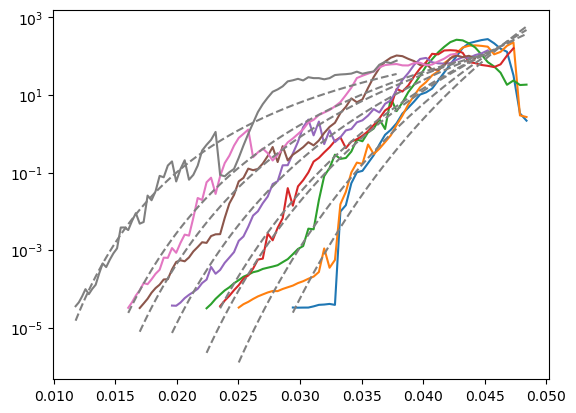

In [212]:
model = nek_resid(result_global.params, xx_list)

for x, y in zip(xx_list, yy_list):
    plt.plot(x, y)

for x, y in zip(xx_list, model):
    plt.plot(x, 10**y, "--", color="grey")

plt.yscale("log")

/tmp/ipykernel_5007/563415715.py:7: RuntimeWarning: invalid value encountered in log10
  c=np.log10(lyapunov_b[idx]),


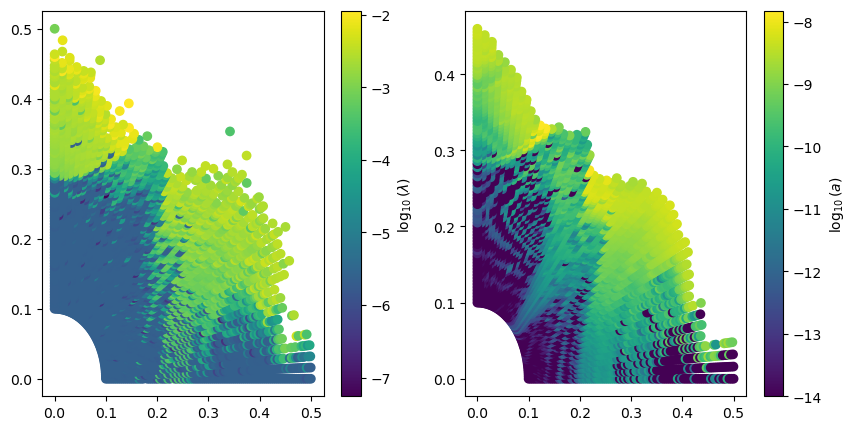

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
idx = -2

axs[0].scatter(
    x=lyap_rr[idx] * np.cos(lyap_aa[idx]),
    y=lyap_rr[idx] * np.sin(lyap_aa[idx]),
    c=np.log10(lyapunov_b[idx]),
)
# add colorbar
cbar = plt.colorbar(axs[0].collections[0], ax=axs[0])
cbar.set_label(r"$\log_{10}(\lambda)$")

axs[1].scatter(
    x=rr_vals_list[idx] * np.cos(aa_vals_list[idx]),
    y=rr_vals_list[idx] * np.sin(aa_vals_list[idx]),
    c=np.log10(a_vals_list[idx]),
    vmin=-14,
)
# add colorbar
cbar = plt.colorbar(axs[1].collections[0], ax=axs[1])
cbar.set_label(r"$\log_{10}(a)$")

/tmp/ipykernel_5007/1337393678.py:7: RuntimeWarning: invalid value encountered in log10
  c=np.log10(lyapunov_b[idx]),


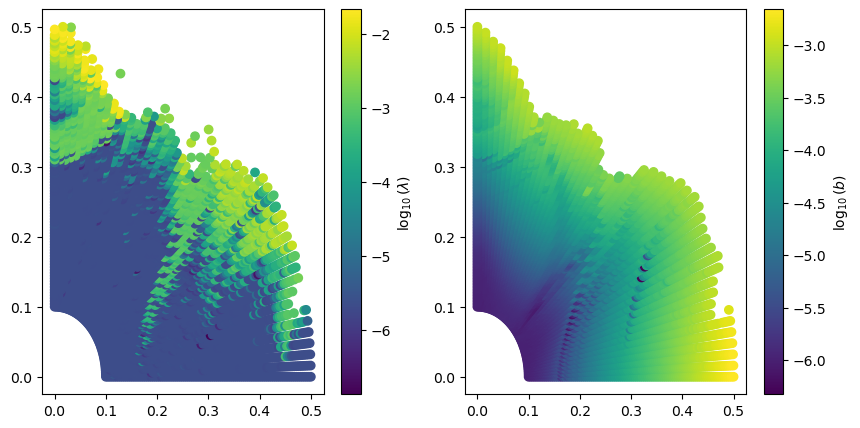

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
idx = 2

axs[0].scatter(
    x=lyap_rr[idx] * np.cos(lyap_aa[idx]),
    y=lyap_rr[idx] * np.sin(lyap_aa[idx]),
    c=np.log10(lyapunov_b[idx]),
)
# add colorbar
cbar = plt.colorbar(axs[0].collections[0], ax=axs[0])
cbar.set_label(r"$\log_{10}(\lambda)$")

axs[1].scatter(
    x=rr_vals_list[idx] * np.cos(aa_vals_list[idx]),
    y=rr_vals_list[idx] * np.sin(aa_vals_list[idx]),
    c=np.log10(b_vals_list[idx]),
    # vmin=-10,
)
# add colorbar
cbar = plt.colorbar(axs[1].collections[0], ax=axs[1])
cbar.set_label(r"$\log_{10}(b)$")

/tmp/ipykernel_5007/208435484.py:7: RuntimeWarning: invalid value encountered in log10
  c=np.log10(lyapunov_b[idx]),


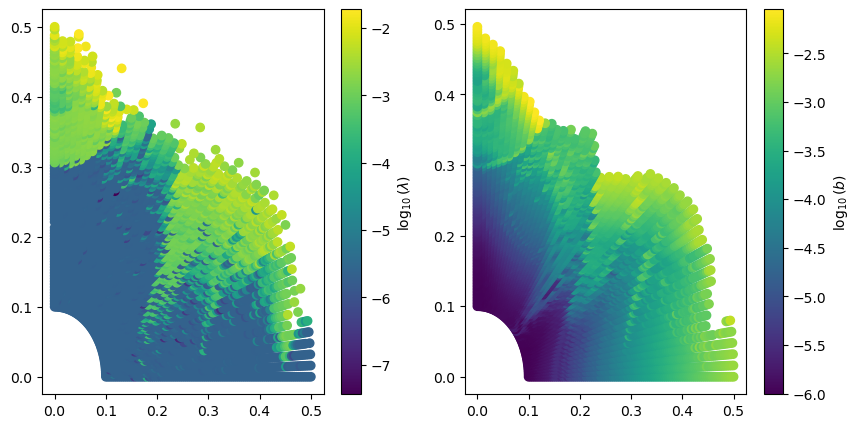

In [178]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
idx = 3

axs[0].scatter(
    x=lyap_rr[idx] * np.cos(lyap_aa[idx]),
    y=lyap_rr[idx] * np.sin(lyap_aa[idx]),
    c=np.log10(lyapunov_b[idx]),
)
# add colorbar
cbar = plt.colorbar(axs[0].collections[0], ax=axs[0])
cbar.set_label(r"$\log_{10}(\lambda)$")

axs[1].scatter(
    x=rr_vals_list[idx] * np.cos(aa_vals_list[idx]),
    y=rr_vals_list[idx] * np.sin(aa_vals_list[idx]),
    c=np.log10(a_vals_list[idx] * 1e6 + b_vals_list[idx]),
    # vmin=-10,
)
# add colorbar
cbar = plt.colorbar(axs[1].collections[0], ax=axs[1])
cbar.set_label(r"$\log_{10}(b)$")

/tmp/ipykernel_5007/4267107638.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(lyapunov_b[idx]) < -4.5


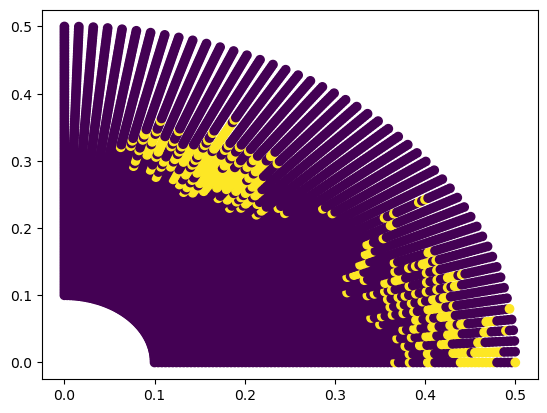

In [154]:
idx_list = np.where(
    np.logical_and(
        np.log10(a_vals_list[idx]) > -9,
        np.log10(lyapunov_b[idx]) < -4.5
    )
)[0]
tmp_c = np.zeros_like(a_vals_list[idx])
tmp_c[idx_list] = 1.0

plt.scatter(
    x=rr_vals_list[idx] * np.cos(aa_vals_list[idx]),
    y=rr_vals_list[idx] * np.sin(aa_vals_list[idx]),
    c=tmp_c
)

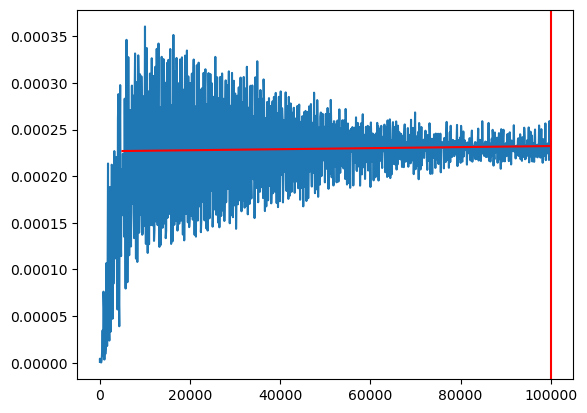

In [158]:
choice_idx = np.random.choice(idx_list)

with h5py.File(f_list[idx][0], "r") as f:
    vx = f[f"track_data/{choice_idx}/time_samples"][...]
    vy = f[f"track_data/{choice_idx}/I_std"][...]
    steps = f[f"track_data/{choice_idx}/steps"][...]
plt.plot(vx, vy**2)
plt.axvline(np.min(steps), color="red")

params = lmfit.Parameters()
params.add('a', value=1.0)
params.add('b', value=vy[0]**2)

mask = np.logical_and(vx > 5000, vx < np.min([1e5, np.min(steps)]))
if np.count_nonzero(mask) < 10:
    mask = vx < np.min([1e5, np.min(steps)])
vx = vx[mask]
vy = vy[mask]

result = lmfit.minimize(linear_resid, params, args=(vx, vy**2))

plt.plot(vx, linear_resid(result.params, vx), color="red")

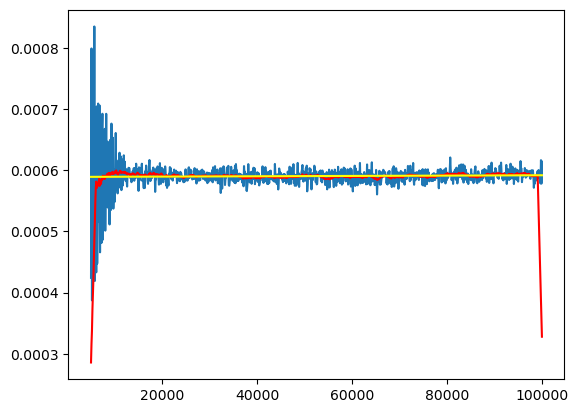

In [142]:
plt.plot(vx, vy**2)
plt.plot(vx, moving_mean(vy**2, 20), color="red")
plt.plot(vx, linear_resid(result.params, vx), color="yellow")

/tmp/ipykernel_5007/388471979.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(lyapunov_b[idx]) < -5.5


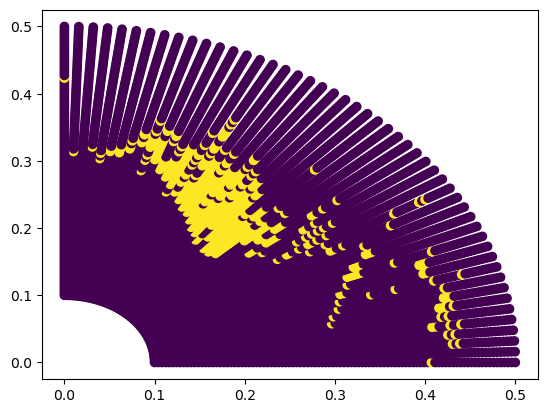

In [101]:
idx_list = np.where(
    np.logical_and(
        np.log10(a_vals_list[idx]) > -10,
        np.log10(lyapunov_b[idx]) < -5.5
    )
)[0]
tmp_c = np.zeros_like(a_vals_list[idx])
tmp_c[idx_list] = 1.0

plt.scatter(
    x=rr_vals_list[idx] * np.cos(aa_vals_list[idx]),
    y=rr_vals_list[idx] * np.sin(aa_vals_list[idx]),
    c=tmp_c,
)

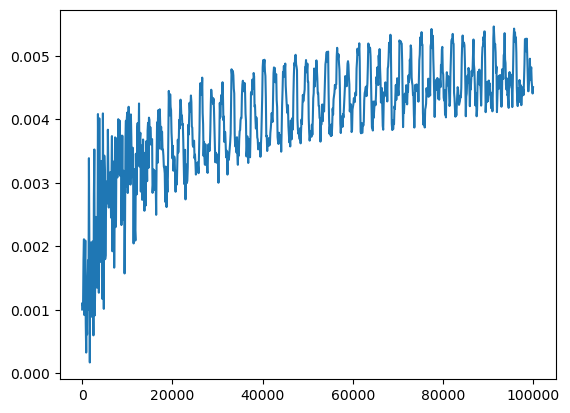

In [102]:
choice_idx = np.random.choice(idx_list)

with h5py.File(f_list[idx][0], "r") as f:
    vx = f[f"track_data/{choice_idx}/time_samples"][...]
    vy = f[f"track_data/{choice_idx}/I_std"][...]
    steps = f[f"track_data/{choice_idx}/steps"][...]
plt.plot(vx, vy)

/tmp/ipykernel_5007/598138167.py:17: RuntimeWarning: invalid value encountered in log10
  c=np.log10(lyapunov_b[idx]),
/tmp/ipykernel_5007/598138167.py:29: RuntimeWarning: invalid value encountered in log10
  axs[2].scatter(np.log10(lyapunov_b[idx]), np.log10(a_vals_list[idx] * 1e6 + b_vals_list[idx]), s=1, c=rr_vals_list[idx], cmap="viridis")


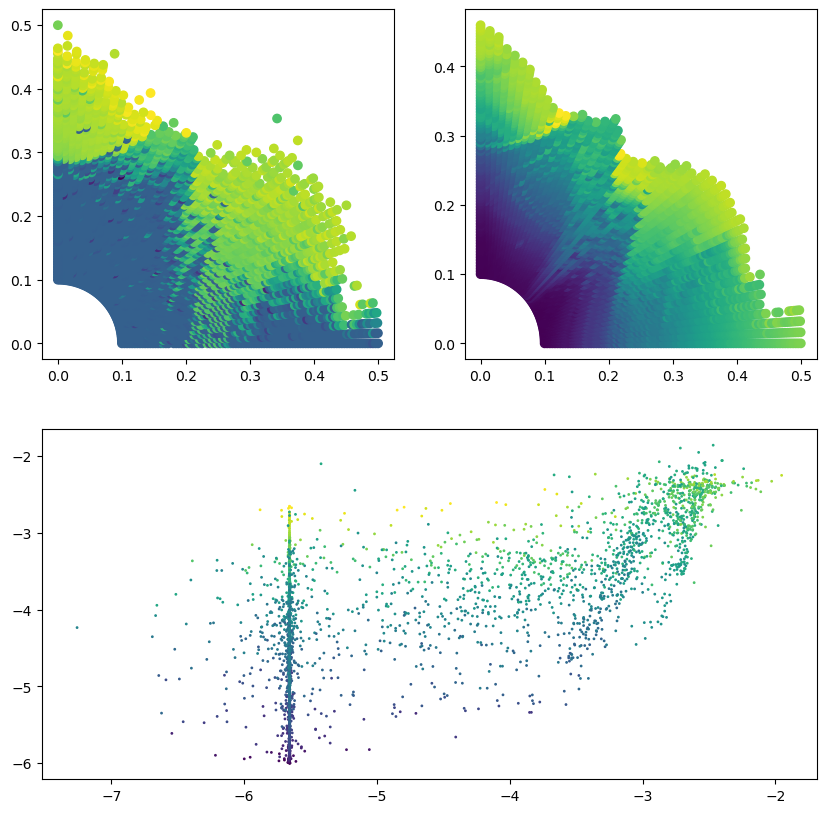

In [186]:
idx = -2
fig = plt.figure(figsize=(10, 10))

# add gridspec
gs = fig.add_gridspec(2, 2)

# add axes
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, :]),
]

axs[0].scatter(
    x=lyap_rr[idx] * np.cos(lyap_aa[idx]),
    y=lyap_rr[idx] * np.sin(lyap_aa[idx]),
    c=np.log10(lyapunov_b[idx]),
)

axs[1].scatter(
    x=rr_vals_list[idx] * np.cos(aa_vals_list[idx]),
    y=rr_vals_list[idx] * np.sin(aa_vals_list[idx]),
    c=np.log10(a_vals_list[idx] * 1e6 + b_vals_list[idx]),
    # vmin=-10
)

# tmp_x = np.linspace(-3, 3, 1000)
# tmp_y = np.abs(np.sin(tmp_x)) + 5*np.exp(-tmp_x**100)*np.cos(tmp_x)
axs[2].scatter(np.log10(lyapunov_b[idx]), np.log10(a_vals_list[idx] * 1e6 + b_vals_list[idx]), s=1, c=rr_vals_list[idx], cmap="viridis")

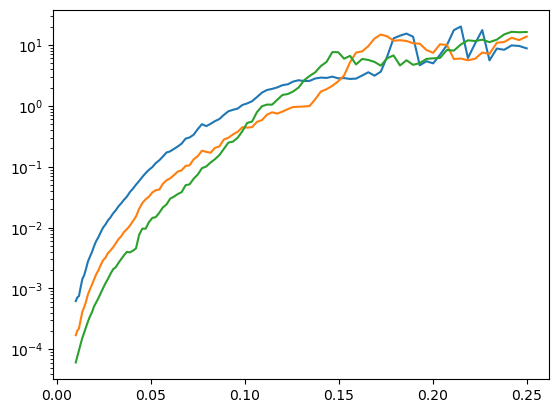

In [186]:
for rr, aa in list(zip(r_mean_list, a_mean_list))[::3]:
    integral = integrate.simps(aa, rr**2)
    plt.plot(rr**2, aa/integral)

plt.yscale("log")

In [180]:
@njit
def nek_d(kappa, I_ast, I):
    return np.exp(-2 * (I_ast/I) ** (1 / (2*kappa)))


def nek_resid(params, x, data=None):
    kappa = params["kappa"].value

    len_x = len(data) if data is not None else 1

    I_ast = [params[f"I_ast_{i}"].value for i in range(len_x)]
    # eps = [params[f"eps_{i}"].value for i in range(len_x)]

    integral = []
    for i in range(len_x):
        x_min = np.min(x)
        x_max = np.max(x)
        print(x_min, x_max)
        iiii = (integrate.quad(lambda s: nek_d(kappa, I_ast[i], s), x_min, x_max)[0])
        print(iiii)
        integral.append(iiii)

    model = [np.log10(nek_d(kappa, I_ast[i], x[i]) / integral[i]) for i in range(len_x)]

    if data is None:
        return model
    
    return np.concatenate([m - d for m, d in zip(model, data)])

In [181]:
xx

array([0.06024793, 0.06224773, 0.06428018, 0.06634527, 0.06844302,
       0.07057341, 0.07273646, 0.07493215, 0.07716049, 0.07942149,
       0.08171513, 0.08404142, 0.08640037, 0.08879196, 0.0912162 ,
       0.09367309, 0.09616264, 0.09868483, 0.10123967, 0.10382716,
       0.1064473 , 0.10910009, 0.11178553, 0.11450362, 0.11725436,
       0.12003775, 0.12285379, 0.12570248, 0.12858382, 0.13149781,
       0.13444444, 0.13742373, 0.14043567, 0.14348026, 0.14655749,
       0.14966738, 0.15280992, 0.1559851 , 0.15919294, 0.16243343,
       0.16570656, 0.16901235, 0.17235078, 0.17572187, 0.1791256 ,
       0.18256198, 0.18603102, 0.1895327 , 0.19306703, 0.19663402,
       0.20023365, 0.20386593, 0.20753086, 0.21122845, 0.21495868,
       0.21872156, 0.22251709, 0.22634527, 0.2302061 , 0.23409958,
       0.23802571, 0.24198449, 0.24597592, 0.25      ])

0.010000000000000002 0.25
7.379784076353738e-10
0.010000000000000002 0.25
7.379784076353738e-10
0.010000000000000002 0.25
7.379784076353738e-10
0.010000000000000002 0.25
7.379784076353738e-10
0.010000000000000002 0.25
7.379784076353738e-10
0.010000000000000002 0.25
7.379784076353738e-10
0.010000000000000002 0.25
7.379784076353738e-10
0.010000000000000002 0.25
7.379784076353738e-10


ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

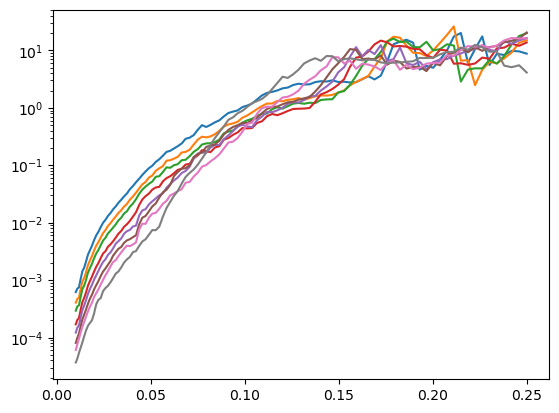

In [192]:
params = lmfit.Parameters()
params.add('kappa', value=0.33, min=0.1, max=3.0, vary=False)
params.add('I_ast_0', value=1.0, min=0.1, max=100)
params.add('I_ast_1', value=1.0, min=0.1, max=100)
params.add('I_ast_2', value=1.0, min=0.1, max=100)
params.add('I_ast_3', value=1.0, min=0.1, max=100)
params.add('I_ast_4', value=1.0, min=0.1, max=100)
params.add('I_ast_5', value=1.0, min=0.1, max=100)
params.add('I_ast_6', value=1.0, min=0.1, max=100)
params.add('I_ast_7', value=1.0, min=0.1, max=100)
# params.add('eps_0', value=-2)
# params.add('eps_1', value=-5)
# params.add('eps_2', value=-5)
# params.add('eps_3', value=-5)
# params.add('eps_4', value=-5)
# params.add('eps_5', value=-5)
# params.add('eps_6', value=-5)
# params.add('eps_7', value=-5)
# params.add('eps_1', expr='eps_0')
# params.add('eps_2', expr='eps_0')
# params.add('eps_3', expr='eps_0')
# params.add('eps_4', expr='eps_0')
# params.add('eps_5', expr='eps_0')
# params.add('eps_6', expr='eps_0')
# params.add('eps_7', expr='eps_0')

mask = np.logical_and(r_unique ** 2 > 0.01, r_unique ** 2 < 0.6)
xx = r_unique[mask] ** 2
yy = np.array(a_mean_list)[:, mask]
for i in range(len(yy)):
    integral = integrate.simps(yy[i], xx)
    yy[i] /= integral
    plt.plot(xx, yy[i])
plt.yscale("log")

result = lmfit.minimize(nek_resid, params, args=(xx,np.log10(yy)))
result

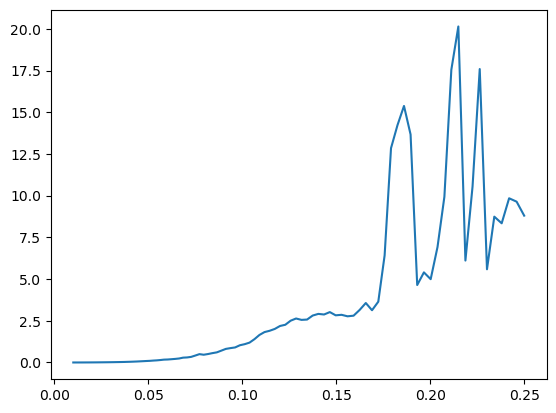

In [188]:
plt.plot(xx, yy[0])

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

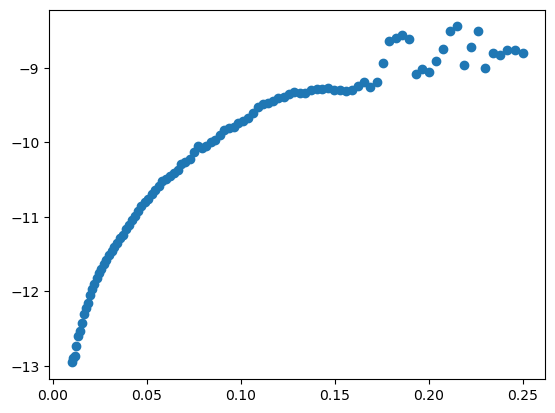

In [173]:
fit_data = nek_resid(result.params, r_unique**2)

for rr, aa, ff in zip(r_mean_list, a_mean_list, fit_data):
    plt.scatter(rr**2, np.log10(aa))
    plt.plot(rr**2, ff, color="k")

plt.ylim(-12, -7)

In [ ]:
import sympy as sp

x = sp.symbols('x', real=True)
I_ast = sp.sym